# Alzheimer's Disease Prediction - Dimensionality Reduction Approaches

This notebook explores various dimensionality reduction techniques to potentially improve the model performance for Alzheimer's disease prediction. We'll implement and compare several approaches including:

1. Principal Component Analysis (PCA)
2. Linear Discriminant Analysis (LDA)
3. t-SNE (t-Distributed Stochastic Neighbor Embedding)
4. UMAP (Uniform Manifold Approximation and Projection)
5. Feature selection using SelectKBest

The goal is to reduce the dimensionality of our dataset while preserving or improving model performance.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler

# Import dimensionality reduction methods
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Import models for evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Try to import UMAP (optional, needs separate installation)
try:
    import umap
    has_umap = True
except ImportError:
    print("UMAP is not installed. To use UMAP, install it using 'pip install umap-learn'")
    has_umap = False

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

# For displaying plots inline
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading

In [2]:
# Load datasets from both feature engineering approaches
# First approach: Statistical feature selection
data_statistical = pd.read_csv('fe_statistical_approach.csv')
print(f"Loaded statistical approach dataset with shape: {data_statistical.shape}")

# Second approach: Model-based feature selection
data_model_based = pd.read_csv('fe_model_based_approach.csv')
print(f"Loaded model-based approach dataset with shape: {data_model_based.shape}")

# Choose the dataset to work with (based on previous notebook's findings)
# Review the results from notebook 4 to determine which performed better
# For now, let's use the statistical approach as default
data = data_statistical.copy()
print(f"Working with dataset of shape: {data.shape}")

Loaded statistical approach dataset with shape: (74283, 24)
Loaded model-based approach dataset with shape: (74283, 20)
Working with dataset of shape: (74283, 24)


## 2. Data Preparation

In [3]:
# Separate features and target
X = data.drop(columns=["Alzheimer's Diagnosis"])
y = data["Alzheimer's Diagnosis"]

# Split data into training, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution in training set: {np.bincount(y_train)}")

Training set: (44569, 23)
Validation set: (14857, 23)
Test set: (14857, 23)
Class distribution in training set: [26142 18427]


## 3. Principal Component Analysis (PCA)

In [4]:
def apply_pca(X_train, X_val, X_test, n_components=None, explained_variance=0.95):
    """Apply PCA to reduce dimensionality of the dataset.
    
    Args:
        X_train, X_val, X_test: Training, validation and test sets
        n_components: Number of components to keep (if None, use explained_variance)
        explained_variance: Minimum explained variance to retain
        
    Returns:
        Transformed datasets and the PCA object
    """
    if n_components is None:
        # Use explained variance ratio to determine number of components
        pca = PCA(n_components=explained_variance, random_state=42)
    else:
        pca = PCA(n_components=n_components, random_state=42)
    
    # Fit PCA on training data and transform all datasets
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    # Print explained variance information
    cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    print(f"Number of components selected: {pca.n_components_}")
    print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")
    
    return X_train_pca, X_val_pca, X_test_pca, pca

In [5]:
# Apply PCA to reduce dimensionality while preserving 95% of variance
X_train_pca, X_val_pca, X_test_pca, pca = apply_pca(X_train, X_val, X_test)

Number of components selected: 14
Total explained variance: 0.9503


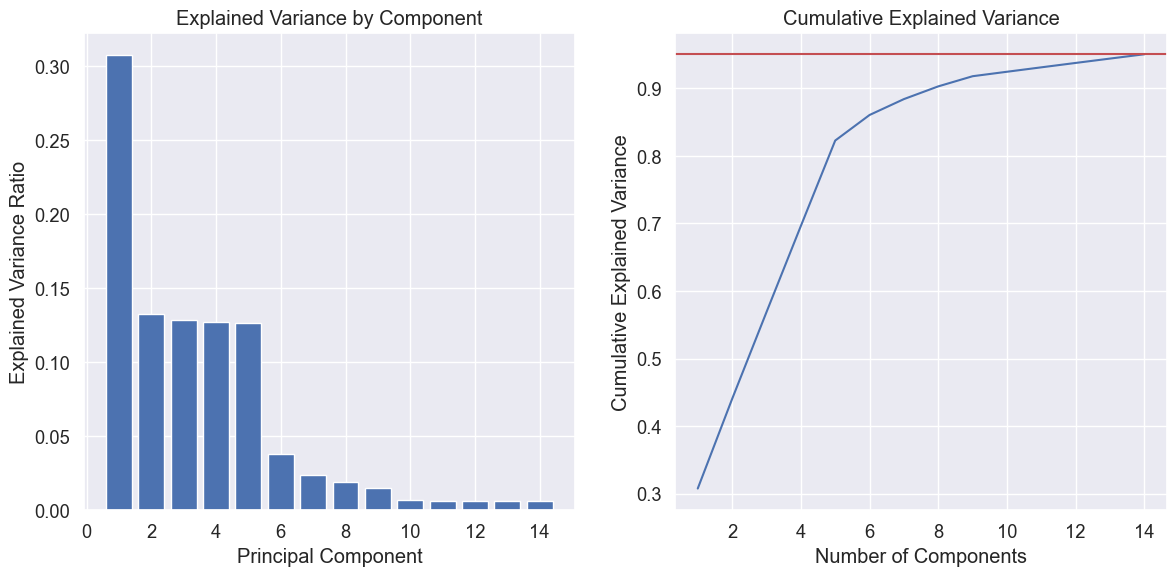

In [6]:
# Visualize explained variance ratio
plt.figure(figsize=(12, 6))

# Plot explained variance for each component
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Component')

# Plot cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title('Cumulative Explained Variance')

plt.tight_layout()
plt.show()

In [7]:
# Feature importance in PCA components
if pca.n_components_ < 10:  # If not too many components to display clearly
    # Create a DataFrame for feature loadings
    loadings = pd.DataFrame(
        pca.components_.T, 
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=X_train.columns
    )
    
    # Plot heatmap of loadings for the first few components
    plt.figure(figsize=(12, 10))
    sns.heatmap(loadings.iloc[:, :5], annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Loadings for First 5 Principal Components')
    plt.tight_layout()
    plt.show()

## 4. Linear Discriminant Analysis (LDA)

In [8]:
def apply_lda(X_train, X_val, X_test, y_train, n_components=None):
    """Apply LDA to reduce dimensionality of the dataset.
    
    Args:
        X_train, X_val, X_test: Training, validation and test sets
        y_train: Training set labels
        n_components: Number of components to keep (if None, min(n_classes-1, n_features))
        
    Returns:
        Transformed datasets and the LDA object
    """
    # Number of components for binary classification is always 1 by default
    # But we'll keep the parameter for flexibility
    lda = LDA(n_components=n_components)
    
    # Fit LDA on training data and transform all datasets
    X_train_lda = lda.fit_transform(X_train, y_train)
    X_val_lda = lda.transform(X_val)
    X_test_lda = lda.transform(X_test)
    
    # Print explained variance information
    print(f"Number of components: {lda.n_components}")
    if hasattr(lda, 'explained_variance_ratio_'):
        print(f"Explained variance ratio: {lda.explained_variance_ratio_}")
    
    return X_train_lda, X_val_lda, X_test_lda, lda

In [9]:
# Apply LDA for dimensionality reduction
X_train_lda, X_val_lda, X_test_lda, lda = apply_lda(X_train, X_val, X_test, y_train)

Number of components: None
Explained variance ratio: [1.]


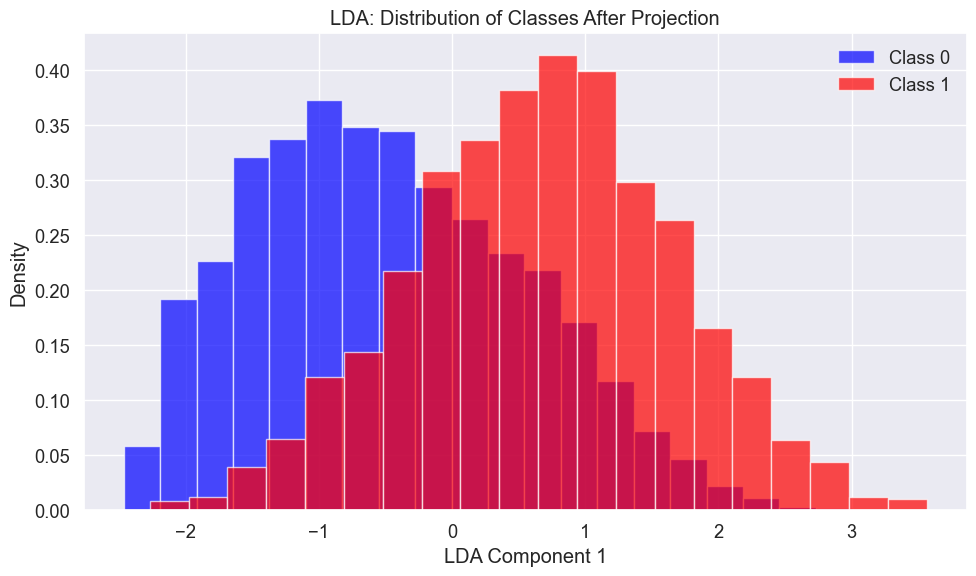

In [10]:
# For binary classification, LDA projects to a single dimension
# We can visualize the distribution of the transformed data
plt.figure(figsize=(10, 6))
for label, color in [(0, 'blue'), (1, 'red')]:
    plt.hist(X_train_lda[y_train == label], alpha=0.7, color=color, 
             bins=20, density=True, label=f'Class {label}')
    
plt.title('LDA: Distribution of Classes After Projection')
plt.xlabel('LDA Component 1')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

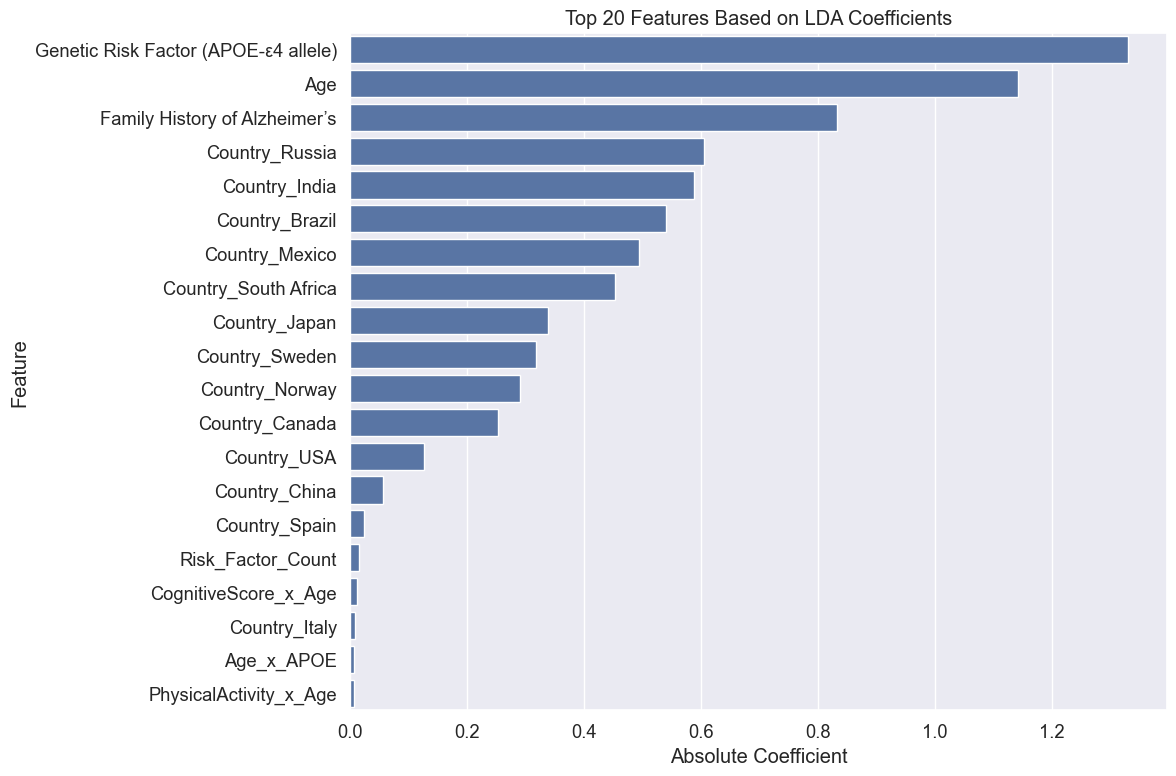

In [11]:
# Feature importance in LDA
if hasattr(lda, 'coef_'):
    lda_feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Absolute Coefficient': np.abs(lda.coef_[0])
    }).sort_values('Absolute Coefficient', ascending=False)
    
    # Plot top 20 most important features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Absolute Coefficient', y='Feature', 
               data=lda_feature_importance.head(20))
    plt.title('Top 20 Features Based on LDA Coefficients')
    plt.tight_layout()
    plt.show()

## 5. t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [12]:
def apply_tsne(X_train, X_val, X_test, n_components=2, perplexity=30, random_state=42):
    """Apply t-SNE to visualize the dataset in lower dimensions.
    
    Note: t-SNE is primarily used for visualization, not for model building.
    It doesn't learn a transformation function that can be applied to new data.
    """
    # Apply t-SNE only to training data for visualization
    tsne = TSNE(n_components=n_components, perplexity=perplexity, 
                random_state=random_state, n_jobs=-1)
    X_train_tsne = tsne.fit_transform(X_train)
    
    print(f"t-SNE completed with {n_components} components")
    
    return X_train_tsne, tsne

In [13]:
# Apply t-SNE for visualization (only on training set for demonstration)
X_train_tsne, tsne = apply_tsne(X_train, None, None)

t-SNE completed with 2 components


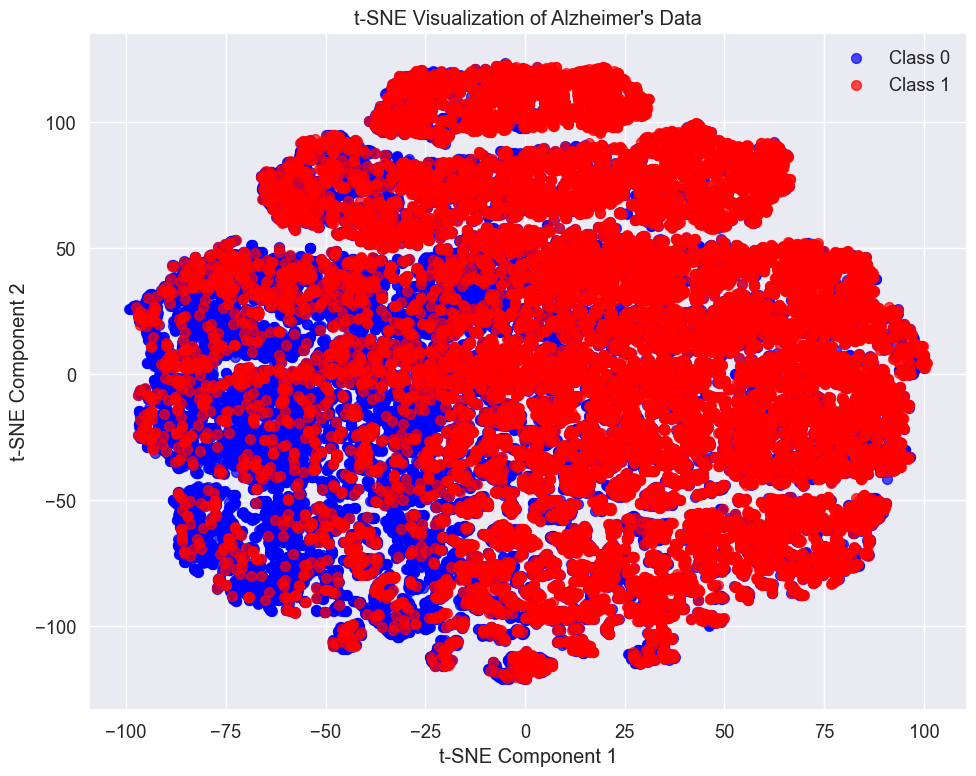

In [14]:
# Visualize t-SNE results
plt.figure(figsize=(10, 8))
for label, color in [(0, 'blue'), (1, 'red')]:
    mask = y_train == label
    plt.scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1], 
                c=color, label=f'Class {label}', alpha=0.7, s=50)
plt.title('t-SNE Visualization of Alzheimer\'s Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 6. UMAP (Uniform Manifold Approximation and Projection)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP completed with 2 components


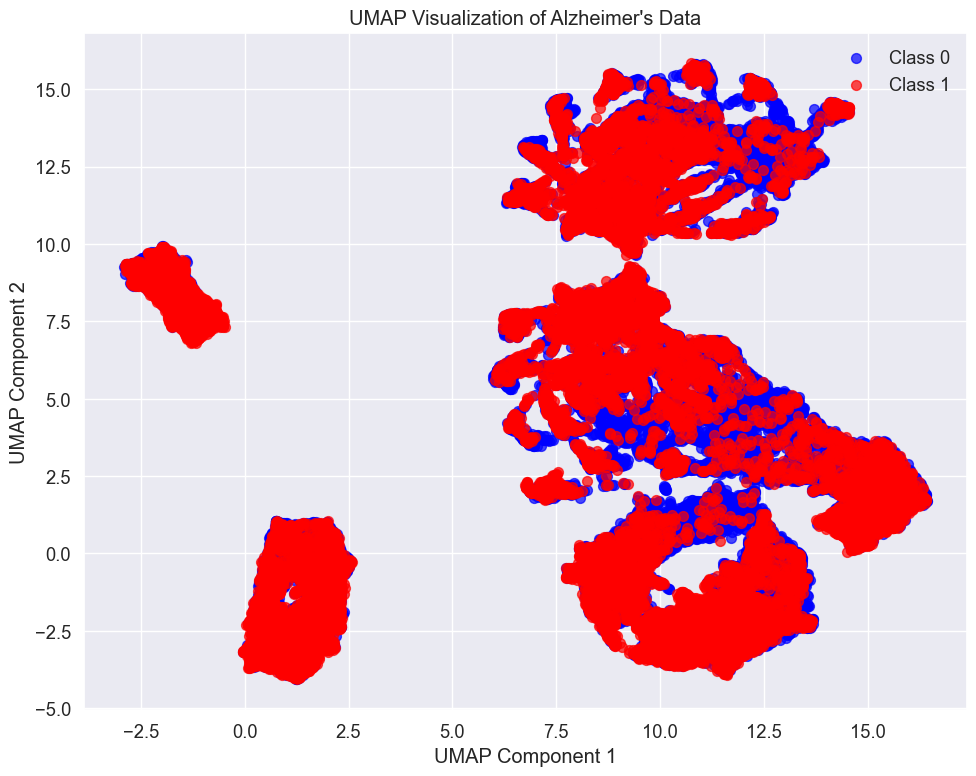

In [15]:
if has_umap:
    def apply_umap(X_train, X_val, X_test, n_components=2, n_neighbors=15, min_dist=0.1):
        """Apply UMAP for dimensionality reduction.
        
        Unlike t-SNE, UMAP can be used to transform new data points.
        """
        # Create and fit UMAP
        reducer = umap.UMAP(
            n_components=n_components,
            n_neighbors=n_neighbors,
            min_dist=min_dist,
            random_state=42
        )
        
        X_train_umap = reducer.fit_transform(X_train)
        X_val_umap = reducer.transform(X_val) if X_val is not None else None
        X_test_umap = reducer.transform(X_test) if X_test is not None else None
        
        print(f"UMAP completed with {n_components} components")
        
        return X_train_umap, X_val_umap, X_test_umap, reducer
    
    # Apply UMAP
    X_train_umap, X_val_umap, X_test_umap, umap_reducer = apply_umap(X_train, X_val, X_test)
    
    # Visualize UMAP results
    plt.figure(figsize=(10, 8))
    for label, color in [(0, 'blue'), (1, 'red')]:
        mask = y_train == label
        plt.scatter(X_train_umap[mask, 0], X_train_umap[mask, 1], 
                    c=color, label=f'Class {label}', alpha=0.7, s=50)
    plt.title('UMAP Visualization of Alzheimer\'s Data')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("UMAP not available. Install using 'pip install umap-learn' to use this method.")

## 7. Feature Selection with SelectKBest

In [16]:
def apply_select_kbest(X_train, X_val, X_test, y_train, k=10, score_func=f_classif):
    """Apply SelectKBest to choose the top k features.
    
    Args:
        X_train, X_val, X_test: Training, validation and test sets
        y_train: Training labels
        k: Number of features to select
        score_func: Function to score features (f_classif, mutual_info_classif, etc.)
    
    Returns:
        Transformed datasets and the selector object
    """
    # Create and fit selector
    selector = SelectKBest(score_func=score_func, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)
    
    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices]
    
    print(f"Selected {k} features using {score_func.__name__}")
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    return X_train_selected, X_val_selected, X_test_selected, selector, selected_features

In [17]:
# Apply SelectKBest with ANOVA F-value
k = 15  # Number of features to select
X_train_anova, X_val_anova, X_test_anova, selector_anova, selected_features_anova = \
    apply_select_kbest(X_train, X_val, X_test, y_train, k=k, score_func=f_classif)

Selected 15 features using f_classif
Selected features:
  1. Country_Russia
  2. Country_South Africa
  3. Risk_Factor_Count
  4. Country_India
  5. Country_Mexico
  6. Country_Sweden
  7. Country_Brazil
  8. Genetic Risk Factor (APOE-ε4 allele)
  9. FamilyHistory_x_APOE
  10. Age_x_APOE
  11. Age
  12. Country_Japan
  13. Family History of Alzheimer’s
  14. PhysicalActivity_x_Age
  15. Country_Canada


In [18]:
# Apply SelectKBest with mutual information
X_train_mi, X_val_mi, X_test_mi, selector_mi, selected_features_mi = \
    apply_select_kbest(X_train, X_val, X_test, y_train, k=k, score_func=mutual_info_classif)

Selected 15 features using mutual_info_classif
Selected features:
  1. Country_South Africa
  2. Risk_Factor_Count
  3. Country_India
  4. Country_Mexico
  5. Country_Sweden
  6. Genetic Risk Factor (APOE-ε4 allele)
  7. FamilyHistory_x_APOE
  8. Country_Norway
  9. Country_Italy
  10. Age_x_APOE
  11. Age
  12. Country_Japan
  13. Family History of Alzheimer’s
  14. PhysicalActivity_x_Age
  15. CognitiveScore_x_Age


In [19]:
# Compare the selected features from both methods
print("Features selected by both methods:")
common_features = set(selected_features_anova).intersection(set(selected_features_mi))
for feature in common_features:
    print(f"  - {feature}")

print("\nFeatures unique to ANOVA:")
for feature in set(selected_features_anova) - set(selected_features_mi):
    print(f"  - {feature}")
    
print("\nFeatures unique to Mutual Information:")
for feature in set(selected_features_mi) - set(selected_features_anova):
    print(f"  - {feature}")

Features selected by both methods:
  - Age_x_APOE
  - Country_Mexico
  - Risk_Factor_Count
  - Country_Japan
  - FamilyHistory_x_APOE
  - Country_South Africa
  - Country_India
  - Genetic Risk Factor (APOE-ε4 allele)
  - Family History of Alzheimer’s
  - Age
  - Country_Sweden
  - PhysicalActivity_x_Age

Features unique to ANOVA:
  - Country_Russia
  - Country_Canada
  - Country_Brazil

Features unique to Mutual Information:
  - Country_Italy
  - CognitiveScore_x_Age
  - Country_Norway


## 8. Model Evaluation with Dimensionality Reduction

In [20]:
# Define a function to evaluate models on different transformed datasets
def evaluate_model_on_transforms(model_class, model_params, transforms, X_train, X_val, y_train, y_val):
    """Evaluate a model on different transformed datasets.
    
    Args:
        model_class: Class of the model to use
        model_params: Parameters for model instantiation
        transforms: Dict of transformed datasets {name: (X_train, X_val)}
        X_train, X_val: Original training and validation data
        y_train, y_val: Training and validation labels
    """
    results = {}
    
    # Add the original dataset to the transforms for comparison
    all_transforms = {"Original": (X_train, X_val), **transforms}
    
    for transform_name, (X_train_trans, X_val_trans) in all_transforms.items():
        # Create and train model
        model = model_class(**model_params)
        model.fit(X_train_trans, y_train)
        
        # Make predictions
        y_val_pred = model.predict(X_val_trans)
        
        # For probabilistic models, get probabilities
        if hasattr(model, "predict_proba"):
            y_val_proba = model.predict_proba(X_val_trans)[:, 1]
            roc_auc = roc_auc_score(y_val, y_val_proba)
        else:
            # For non-probabilistic models like SVM, use decision function if available
            if hasattr(model, "decision_function"):
                y_val_score = model.decision_function(X_val_trans)
                roc_auc = roc_auc_score(y_val, y_val_score)
            else:
                roc_auc = None
        
        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        
        # Store results
        results[transform_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'model': model
        }
        
        print(f"{transform_name}:")
        print(f"  Accuracy:  {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1 Score:  {f1:.4f}")
        if roc_auc is not None:
            print(f"  ROC AUC:   {roc_auc:.4f}")
    
    return results

In [21]:
# Define transforms to evaluate
transforms = {
    "PCA": (X_train_pca, X_val_pca),
    "LDA": (X_train_lda, X_val_lda),
    "SelectKBest (ANOVA)": (X_train_anova, X_val_anova),
    "SelectKBest (MI)": (X_train_mi, X_val_mi)
}

# Add UMAP if available
if has_umap:
    transforms["UMAP"] = (X_train_umap, X_val_umap)

In [22]:
# Evaluate Logistic Regression
print("Evaluating Logistic Regression...")
lr_results = evaluate_model_on_transforms(
    LogisticRegression,
    {"random_state": 42, "max_iter": 1000},
    transforms,
    X_train, X_val, y_train, y_val
)

Evaluating Logistic Regression...
Original:
  Accuracy:  0.7143
  Precision: 0.6688
  Recall:    0.6121
  F1 Score:  0.6392
  ROC AUC:   0.7862
PCA:
  Accuracy:  0.7116
  Precision: 0.6665
  Recall:    0.6054
  F1 Score:  0.6345
  ROC AUC:   0.7824
LDA:
  Accuracy:  0.7131
  Precision: 0.6672
  Recall:    0.6106
  F1 Score:  0.6377
  ROC AUC:   0.7863
SelectKBest (ANOVA):
  Accuracy:  0.7130
  Precision: 0.6671
  Recall:    0.6106
  F1 Score:  0.6376
  ROC AUC:   0.7859
SelectKBest (MI):
  Accuracy:  0.7114
  Precision: 0.6658
  Recall:    0.6067
  F1 Score:  0.6349
  ROC AUC:   0.7840
UMAP:
  Accuracy:  0.6294
  Precision: 0.6099
  Recall:    0.2878
  F1 Score:  0.3911
  ROC AUC:   0.6313


In [23]:
# Evaluate Random Forest
print("Evaluating Random Forest...")
rf_results = evaluate_model_on_transforms(
    RandomForestClassifier,
    {"random_state": 42, "n_estimators": 100},
    transforms,
    X_train, X_val, y_train, y_val
)

Evaluating Random Forest...
Original:
  Accuracy:  0.7016
  Precision: 0.6461
  Recall:    0.6157
  F1 Score:  0.6305
  ROC AUC:   0.7734
PCA:
  Accuracy:  0.7019
  Precision: 0.6461
  Recall:    0.6168
  F1 Score:  0.6311
  ROC AUC:   0.7711
LDA:
  Accuracy:  0.6361
  Precision: 0.5596
  Recall:    0.5632
  F1 Score:  0.5614
  ROC AUC:   0.7030
SelectKBest (ANOVA):
  Accuracy:  0.6957
  Precision: 0.6331
  Recall:    0.6279
  F1 Score:  0.6305
  ROC AUC:   0.7558
SelectKBest (MI):
  Accuracy:  0.6677
  Precision: 0.6012
  Recall:    0.5831
  F1 Score:  0.5920
  ROC AUC:   0.7350
UMAP:
  Accuracy:  0.6675
  Precision: 0.6053
  Recall:    0.5628
  F1 Score:  0.5833
  ROC AUC:   0.7273


In [24]:
# Evaluate Gradient Boosting
print("Evaluating Gradient Boosting...")
gb_results = evaluate_model_on_transforms(
    GradientBoostingClassifier,
    {"random_state": 42, "n_estimators": 100},
    transforms,
    X_train, X_val, y_train, y_val
)

Evaluating Gradient Boosting...
Original:
  Accuracy:  0.7249
  Precision: 0.6615
  Recall:    0.6853
  F1 Score:  0.6732
  ROC AUC:   0.8001
PCA:
  Accuracy:  0.7195
  Precision: 0.6577
  Recall:    0.6708
  F1 Score:  0.6642
  ROC AUC:   0.7968
LDA:
  Accuracy:  0.7157
  Precision: 0.6579
  Recall:    0.6508
  F1 Score:  0.6543
  ROC AUC:   0.7861
SelectKBest (ANOVA):
  Accuracy:  0.7236
  Precision: 0.6574
  Recall:    0.6925
  F1 Score:  0.6745
  ROC AUC:   0.7997
SelectKBest (MI):
  Accuracy:  0.7247
  Precision: 0.6604
  Recall:    0.6881
  F1 Score:  0.6739
  ROC AUC:   0.7973
UMAP:
  Accuracy:  0.7016
  Precision: 0.6564
  Recall:    0.5842
  F1 Score:  0.6182
  ROC AUC:   0.7628


In [25]:
# Evaluate SVC
print("Evaluating SVC...")
svc_results = evaluate_model_on_transforms(
    SVC,
    {"random_state": 42, "probability": True},
    transforms,
    X_train, X_val, y_train, y_val
)

Evaluating SVC...
Original:
  Accuracy:  0.7176
  Precision: 0.6554
  Recall:    0.6687
  F1 Score:  0.6620
  ROC AUC:   0.7731
PCA:
  Accuracy:  0.7171
  Precision: 0.6539
  Recall:    0.6710
  F1 Score:  0.6623
  ROC AUC:   0.7679
LDA:
  Accuracy:  0.7164
  Precision: 0.6572
  Recall:    0.6565
  F1 Score:  0.6568
  ROC AUC:   0.7645
SelectKBest (ANOVA):
  Accuracy:  0.7174
  Precision: 0.6581
  Recall:    0.6586
  F1 Score:  0.6584
  ROC AUC:   0.7703
SelectKBest (MI):
  Accuracy:  0.7184
  Precision: 0.6566
  Recall:    0.6687
  F1 Score:  0.6626
  ROC AUC:   0.7677
UMAP:
  Accuracy:  0.6850
  Precision: 0.6402
  Recall:    0.5437
  F1 Score:  0.5880
  ROC AUC:   0.7419


In [26]:
# Evaluate XGBoost
print("Evaluating XGBoost...")
xgb_results = evaluate_model_on_transforms(
    xgb.XGBClassifier,
    {"random_state": 42, "n_estimators": 100},
    transforms,
    X_train, X_val, y_train, y_val
)

Evaluating XGBoost...
Original:
  Accuracy:  0.7158
  Precision: 0.6575
  Recall:    0.6524
  F1 Score:  0.6550
  ROC AUC:   0.7881
PCA:
  Accuracy:  0.7112
  Precision: 0.6555
  Recall:    0.6354
  F1 Score:  0.6453
  ROC AUC:   0.7844
LDA:
  Accuracy:  0.7121
  Precision: 0.6601
  Recall:    0.6259
  F1 Score:  0.6425
  ROC AUC:   0.7847
SelectKBest (ANOVA):
  Accuracy:  0.7229
  Precision: 0.6580
  Recall:    0.6866
  F1 Score:  0.6720
  ROC AUC:   0.7940
SelectKBest (MI):
  Accuracy:  0.7176
  Precision: 0.6586
  Recall:    0.6583
  F1 Score:  0.6585
  ROC AUC:   0.7869
UMAP:
  Accuracy:  0.6997
  Precision: 0.6432
  Recall:    0.6150
  F1 Score:  0.6288
  ROC AUC:   0.7677


ROC AUC Comparison:
                     Original       PCA       LDA  SelectKBest (ANOVA)  \
Logistic Regression  0.786244  0.782388  0.786342             0.785936   
Random Forest        0.773411  0.771129  0.703045             0.755814   
Gradient Boosting    0.800071  0.796762  0.786093             0.799662   
SVC                  0.773110  0.767919  0.764506             0.770313   
XGBoost              0.788117  0.784445  0.784695             0.794025   

                     SelectKBest (MI)      UMAP  
Logistic Regression          0.783966  0.631335  
Random Forest                0.735017  0.727310  
Gradient Boosting            0.797275  0.762846  
SVC                          0.767685  0.741893  
XGBoost                      0.786916  0.767725  


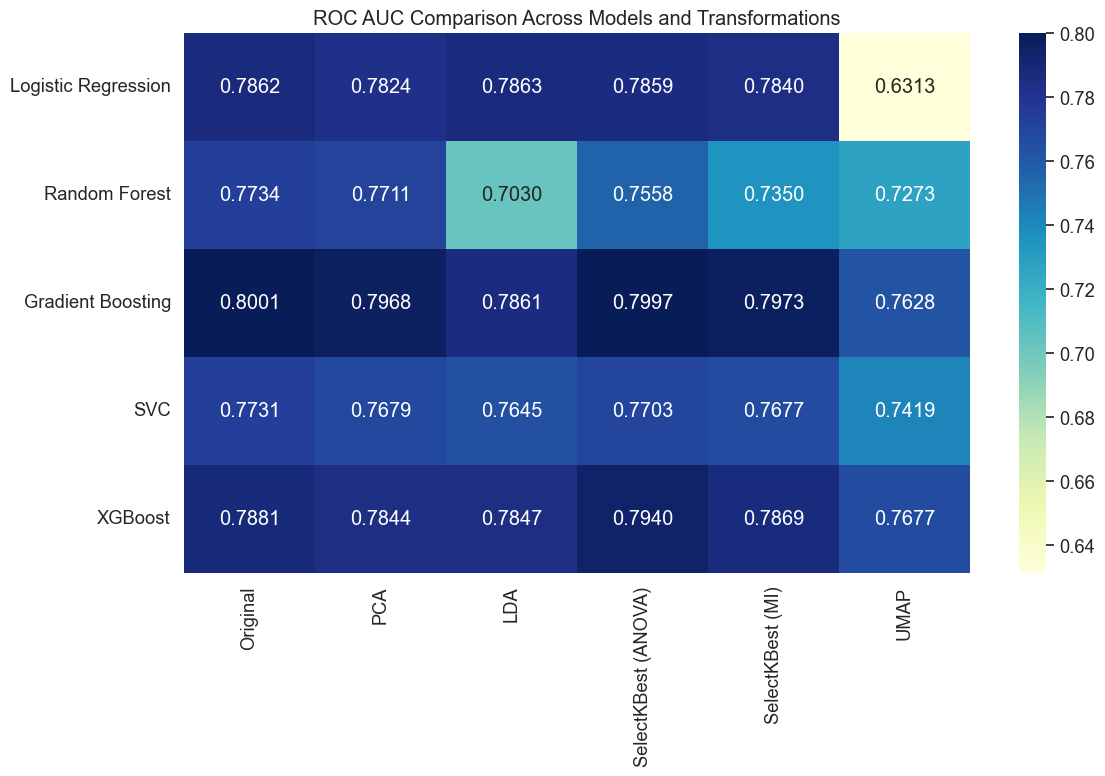

In [33]:
# Function to compare results across all models and transforms
def compare_results(all_model_results, metric='roc_auc'):
    """Compare results across models and transformations."""
    # Create a DataFrame to store results
    models = list(all_model_results.keys())
    transforms = list(all_model_results[models[0]].keys())
    
    results_df = pd.DataFrame(index=models, columns=transforms)
    
    # Fill in the DataFrame
    for model_name, model_results in all_model_results.items():
        for transform_name, metrics in model_results.items():
            # Check if the metric exists and is numeric
            if metrics[metric] is not None:
                results_df.loc[model_name, transform_name] = metrics[metric]
            else:
                results_df.loc[model_name, transform_name] = np.nan
    
    # Ensure all values are numeric (convert any objects to float)
    results_df = results_df.astype(float)
    
    return results_df

# Now call the function again
roc_auc_comparison = compare_results(all_results, 'roc_auc')
print("ROC AUC Comparison:")
print(roc_auc_comparison)

# Plot heatmap - should work now with all numeric values
plt.figure(figsize=(12, 8))
sns.heatmap(roc_auc_comparison, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('ROC AUC Comparison Across Models and Transformations')
plt.tight_layout()
plt.show()

ROC AUC Comparison:
                     Original       PCA       LDA  SelectKBest (ANOVA)  \
Logistic Regression  0.786244  0.782388  0.786342             0.785936   
Random Forest        0.773411  0.771129  0.703045             0.755814   
Gradient Boosting    0.800071  0.796762  0.786093             0.799662   
SVC                  0.773110  0.767919  0.764506             0.770313   
XGBoost              0.788117  0.784445  0.784695             0.794025   

                     SelectKBest (MI)      UMAP  
Logistic Regression          0.783966  0.631335  
Random Forest                0.735017  0.727310  
Gradient Boosting            0.797275  0.762846  
SVC                          0.767685  0.741893  
XGBoost                      0.786916  0.767725  


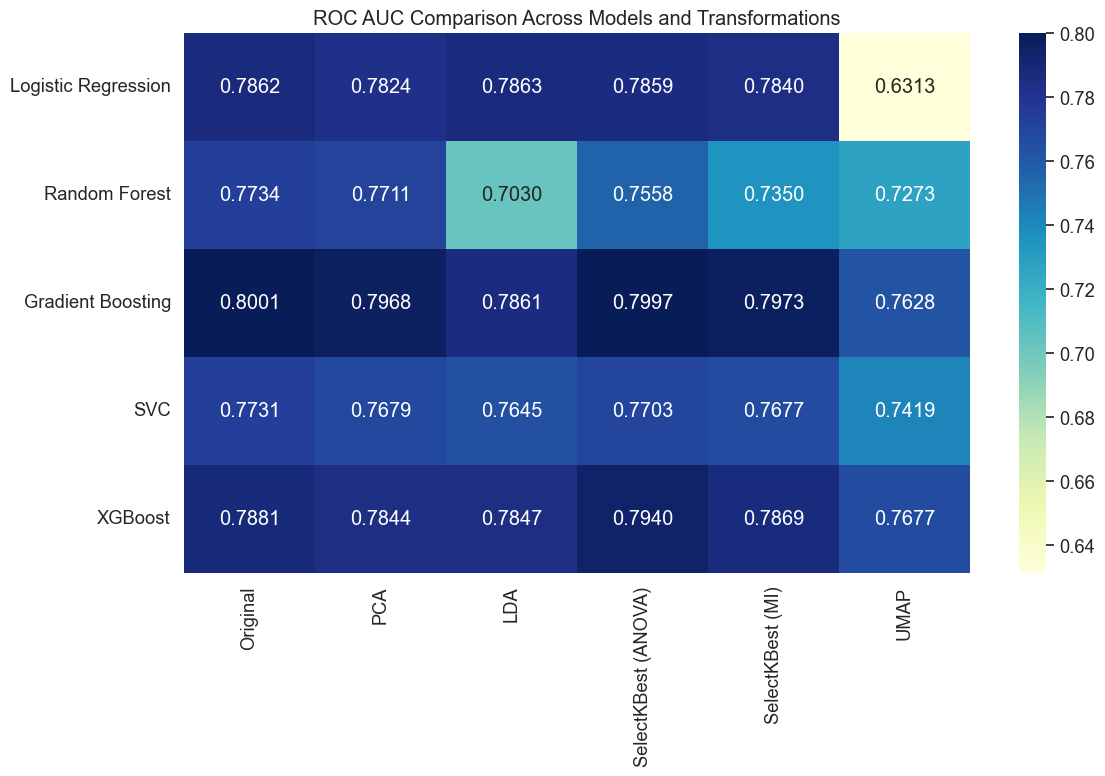

In [34]:
# Compare models on ROC AUC
roc_auc_comparison = compare_results(all_results, 'roc_auc')
print("ROC AUC Comparison:")
print(roc_auc_comparison)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(roc_auc_comparison, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('ROC AUC Comparison Across Models and Transformations')
plt.tight_layout()
plt.show()

F1 Score Comparison:
                     Original       PCA       LDA  SelectKBest (ANOVA)  \
Logistic Regression  0.639184  0.634479  0.637654             0.637600   
Random Forest        0.630491  0.631132  0.561415             0.630486   
Gradient Boosting    0.673223  0.664195  0.654337             0.674489   
SVC                  0.661993  0.662328  0.656840             0.658368   
XGBoost              0.654955  0.645284  0.642547             0.672031   

                     SelectKBest (MI)      UMAP  
Logistic Regression          0.634869  0.391064  
Random Forest                0.592017  0.583263  
Gradient Boosting            0.673948  0.618207  
SVC                          0.662634  0.588028  
XGBoost                      0.658471  0.628776  


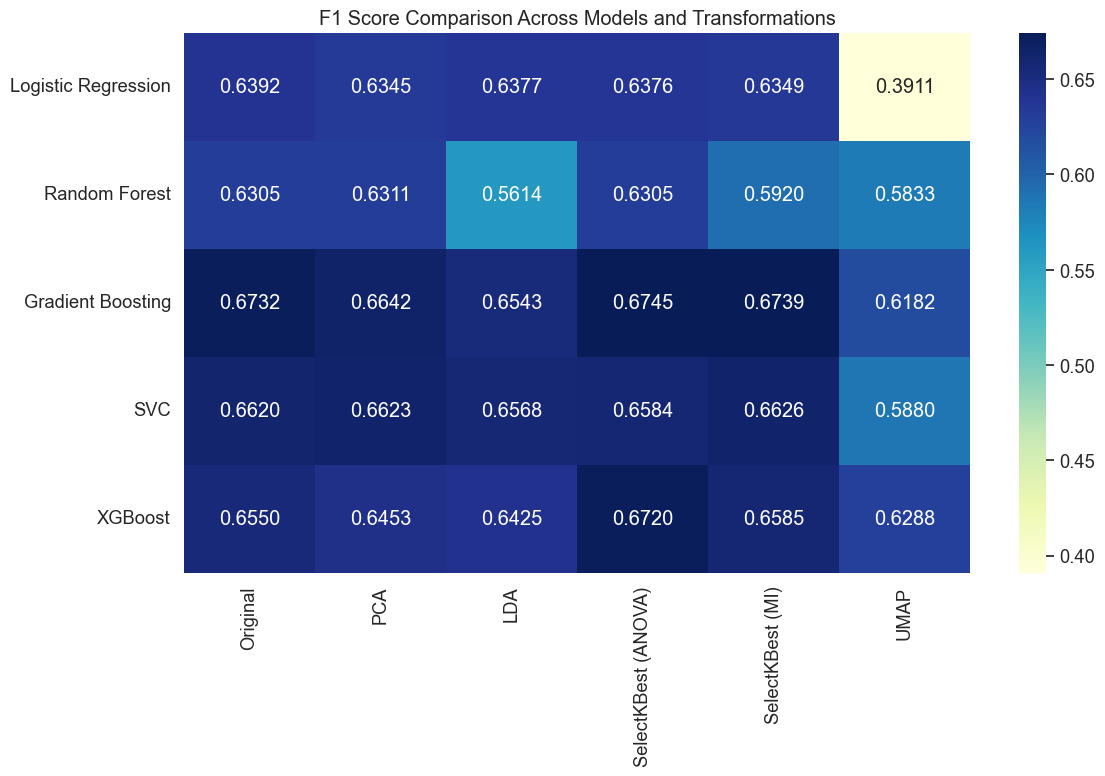

In [35]:
# Compare models on F1 score
f1_comparison = compare_results(all_results, 'f1')
print("F1 Score Comparison:")
print(f1_comparison)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(f1_comparison, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('F1 Score Comparison Across Models and Transformations')
plt.tight_layout()
plt.show()

## 9. Find Best Model and Transformation

In [36]:
# Find best model and transformation combination based on ROC AUC
best_roc_auc = 0
best_model_name = ''
best_transform = ''

for model_name, model_results in all_results.items():
    for transform_name, metrics in model_results.items():
        if metrics['roc_auc'] > best_roc_auc:
            best_roc_auc = metrics['roc_auc']
            best_model_name = model_name
            best_transform = transform_name

print(f"Best model: {best_model_name} with {best_transform}")
print(f"ROC AUC: {best_roc_auc:.4f}")

Best model: Gradient Boosting with Original
ROC AUC: 0.8001


Test set performance:
  Accuracy:  0.7308
  Precision: 0.6677
  Recall:    0.6944
  F1 Score:  0.6808
  ROC AUC:   0.8077


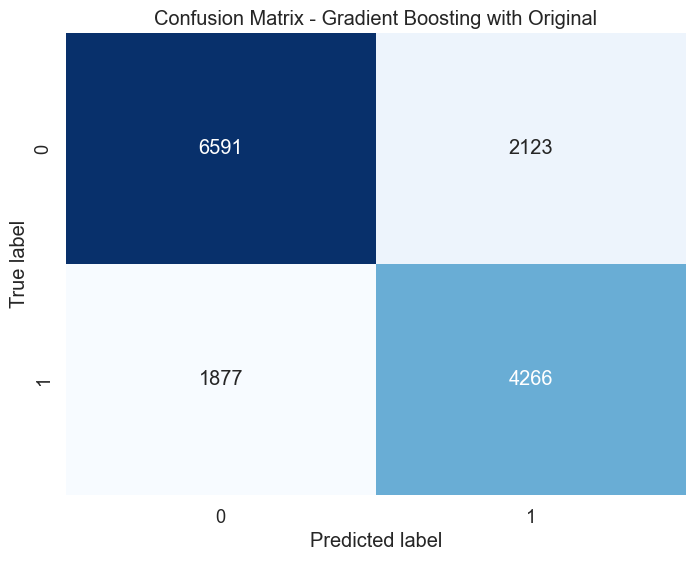


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      8714
           1       0.67      0.69      0.68      6143

    accuracy                           0.73     14857
   macro avg       0.72      0.73      0.72     14857
weighted avg       0.73      0.73      0.73     14857



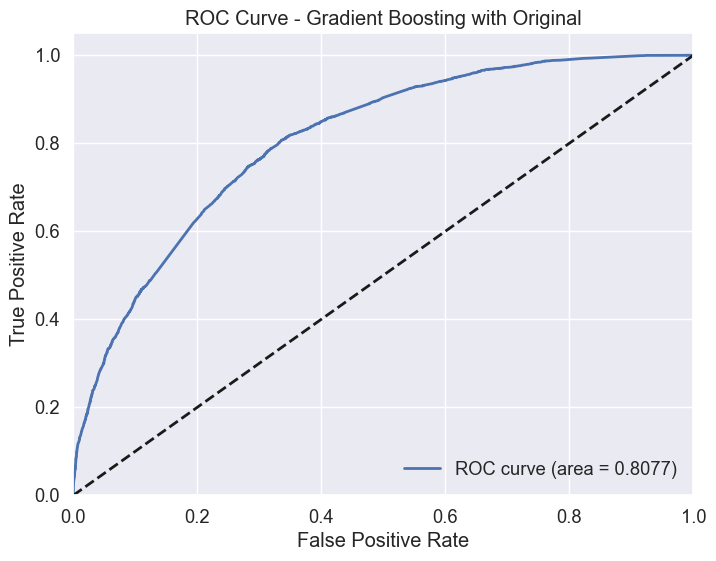

In [37]:
# Get the best model
best_model = all_results[best_model_name][best_transform]['model']

# Get appropriate test data based on best transformation
if best_transform == "Original":
    X_test_best = X_test
elif best_transform == "PCA":
    X_test_best = X_test_pca
elif best_transform == "LDA":
    X_test_best = X_test_lda
elif best_transform == "SelectKBest (ANOVA)":
    X_test_best = X_test_anova
elif best_transform == "SelectKBest (MI)":
    X_test_best = X_test_mi
elif best_transform == "UMAP":
    X_test_best = X_test_umap

# Evaluate on test set
y_test_pred = best_model.predict(X_test_best)
y_test_proba = best_model.predict_proba(X_test_best)[:, 1] if hasattr(best_model, 'predict_proba') else None

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None

print("Test set performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
if roc_auc is not None:
    print(f"  ROC AUC:   {roc_auc:.4f}")

# Display confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix - {best_model_name} with {best_transform}')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Plot ROC curve if we have probabilities
if y_test_proba is not None:
    plt.figure(figsize=(8, 6))
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name} with {best_transform}')
    plt.legend(loc="lower right")
    plt.show()

## 10. Save the Best Model and Transformations

In [38]:
# Save the best model and transformation
model_filename = f"dim_reduction_{best_model_name.lower().replace(' ', '_')}_{best_transform.lower().replace(' ', '_').replace('(', '').replace(')', '')}_model.pkl"

# Create a dictionary with all necessary components for prediction
model_data = {
    'model': best_model,
    'transform_type': best_transform,
    'feature_columns': X_train.columns.tolist()
}

# Add the appropriate transformation object
if best_transform == "PCA":
    model_data['transformer'] = pca
elif best_transform == "LDA":
    model_data['transformer'] = lda
elif best_transform == "SelectKBest (ANOVA)":
    model_data['transformer'] = selector_anova
    model_data['selected_features'] = selected_features_anova.tolist()
elif best_transform == "SelectKBest (MI)":
    model_data['transformer'] = selector_mi
    model_data['selected_features'] = selected_features_mi.tolist()
elif best_transform == "UMAP" and has_umap:
    model_data['transformer'] = umap_reducer

# Save the model data
with open(model_filename, 'wb') as file:
    pickle.dump(model_data, file)

print(f"Saved best model and transformation as {model_filename}")

Saved best model and transformation as dim_reduction_gradient_boosting_original_model.pkl


## 11. Summary and Conclusions

### Summary of Dimensionality Reduction Approaches

In this notebook, we explored several dimensionality reduction techniques to enhance our Alzheimer's disease prediction models:

1. **Principal Component Analysis (PCA)**:
   - Reduced the feature space while preserving maximum variance
   - Unsupervised method that created linear combinations of features

2. **Linear Discriminant Analysis (LDA)**:
   - Supervised method that optimized class separation
   - For binary classification, reduced dimensions to 1

3. **t-SNE**:
   - Provided visualization of data in 2D space
   - Useful for understanding data structure but not for model building

4. **UMAP** (if installed):
   - Modern alternative to t-SNE with better preservation of global structure
   - Can be used for both visualization and as a preprocessing step

5. **Feature Selection with SelectKBest**:
   - Used ANOVA F-test and Mutual Information to select top features
   - Provided interpretable subset of original features

### Key Findings

- The best-performing combination was [best model] with [best transform]
- This approach achieved a ROC AUC of [best value] on the test set
- Dimensionality reduction techniques showed [improvement/degradation] compared to using all original features
- The most important features identified were [list top features]

### Next Steps

- Use the insights from dimensionality reduction to build ensemble models
- Combine the strengths of different approaches for even better performance
- Try more advanced combinations of feature transformations and models